# Train a heterogenous system with SNN and CNN for Fashion MNIST dataset


*   INT8 Quantization of weights
*   beta = 1
*   num_steps = 3
*   bias = False
*   Fashion MNIST images resized from 28x28 to 14x14 image size for ease of simulation

## Neuron parameters:


*   The decay rate(beta) is set to 1 which means no decay. The LIF neuron becomes
IF neuron in this case. This is more hardware efficient and doesn't have much significant impact on the accuracy.
*   Time step of 10 gives better accuracy but it is set to 3 for ease of RTL simulation.

## Imports

In [ ]:
# !pip install snntorch==0.8.1
!pip install jedi --quiet
!pip install snntorch --quiet
!pip install brevitas --quiet

In [ ]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikegen
from snntorch import spikeplot as splt
from snntorch.functional import quant

import brevitas.nn as qnn

import torch
from torchvision import transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import os

# from torchsummary import summary
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix


## DataLoaders

In [ ]:
base_path = '/content/drive/My Drive/project_aug/v4'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([
            transforms.Resize((14,14)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

train_data = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

valid_size=0.2
train_length= len(train_data)

indices = [i for i in range (train_length)]
np.random.shuffle(indices)

split = int(np.floor(valid_size*train_length))
train_idx= indices[split:]
valid_idx= indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

num_workers=0
batch_size=50

train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

print(f"Training data size : {train_idx.__len__()}, Validation data size : {valid_idx.__len__()}, Test data size : {test_loader.dataset.__len__()}")

100%|██████████| 26421880/26421880 [00:04<00:00, 5757717.80it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 169014.33it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3130225.88it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7448181.09it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Training data size : 48000, Validation data size : 12000, Test data size : 10000


## Architecture

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 1

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, in_channels, out_channels, kernal_size, padding, use_pool=False):
    super(ConvNet,self).__init__()
    # self.conv=nn.Conv2d(in_channels,out_channels,kernal_size,padding=padding)
    self.conv = qnn.QuantConv2d(in_channels, out_channels, kernal_size, padding=padding, bias=False, weight_bit_width=8)
    self.use_pool = use_pool
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
    self.activation= nn.ReLU()

  def forward(self,data):
    if self.use_pool:
      return self.activation(self.pool(self.conv(data)));
    else:
      return self.activation(self.conv(data));


In [ ]:
class SnnNet(nn.Module):
  def __init__(self,num_steps,in_channels=8,out_channels=16, use_pool=False):
    super(SnnNet,self).__init__()
    self.use_pool = use_pool
    self.num_steps = num_steps

    qlif = quant.state_quant(num_bits=8, uniform=False, thr_centered=True)

    self.conv = qnn.QuantConv2d(in_channels, out_channels, kernel_size=3,padding=0,stride=1, bias=False, weight_bit_width=8)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.activation = snn.Leaky(beta=beta, spike_grad=spike_grad, state_quant=qlif, reset_mechanism = "zero")

  def forward(self,data):
    self.activation.reset_mem()
    out = []
    mems_out = []
    for step in range(self.num_steps):
      output = self.conv(data[step])
      spike_out, mem_out = self.activation(output)

      if self.use_pool:
        spike_out = self.pool(spike_out);
        mem_out = self.pool(mem_out);

      out.append(spike_out)
      mems_out.append(mem_out)

    return torch.stack(out,dim=0), torch.stack(mems_out,dim=0)


In [ ]:
class Net(nn.Module):
  def __init__(self,num_steps=0, use_spike=False):
    super(Net,self).__init__()
    self.use_spike = use_spike
    self.num_steps = num_steps
    self.mainArch = self.createNet()
    self.fcs = self.createfcs()
    self.layer1_output = None
    self.spike_encoded_input = None
    self.layer2_output_spk = None
    self.layer2_output_mem = None
    self.layer2_output = None
    self.spike_output = None

  def createNet(self):
    layers = [ConvNet(1,8,5,0, True)]
    if self.use_spike:
      layers.append(SnnNet(num_steps=self.num_steps,use_pool=False))
    else:
      layers.append(ConvNet(8,16,3,0,use_pool=False))

    layers.append(ConvNet(16,16,1,0, False))
    return nn.Sequential(*layers)

  def createfcs(self):
    return nn.Sequential(
        nn.Dropout(0.2),
        qnn.QuantLinear(3*3*16,512, bias=True, weight_bit_width=8),
        nn.ReLU(),
        nn.Dropout(0.2),
        qnn.QuantLinear(512,256, bias=True, weight_bit_width=8),
        nn.ReLU(),
        nn.Dropout(0.2),
        qnn.QuantLinear(256,10, bias=True, weight_bit_width=8)
    )

  def forward(self, data):
    x= data
    self.layer1_output = self.mainArch[0](x)
    if self.use_spike:   # Spike encoding on the output of the first layer
      self.spike_encoded_input = spikegen.rate(self.layer1_output, self.num_steps)
      self.layer2_output, self.layer2_output_mem = self.mainArch[1](self.spike_encoded_input)
      self.spike_output = self.layer2_output
      self.layer2_output = torch.sum(self.layer2_output, dim=0)
    else:
      self.layer2_output = self.mainArch[1](self.layer1_output)
    x = self.mainArch[2](self.layer2_output)
    x = x.view(-1, 3 * 3 * 16)
    return self.fcs(x)


## Testing

In [ ]:
for idx, data in enumerate(train_loader):
  print(data[0].shape)
  image = data[0][0,...].to(device)
  print(image.shape)
  break

torch.Size([50, 1, 14, 14])
torch.Size([1, 14, 14])


In [ ]:
# Net without spike
net = Net(use_spike=False).to(device)
finalNet = net(image.to(device))
print(finalNet.shape)

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1419: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1921.)
  return super().rename(names)


torch.Size([1, 10])


In [ ]:
# Net without spike
net = Net(num_steps=1, use_spike=True).to(device)
finalNet = net(image.to(device))
print(finalNet.shape)

torch.Size([1, 10])


## Training Loop

In [ ]:
use_cuda=True
def trainNet(model, optimizer, name, epochs):

    loss_keeper={'train':[],'valid':[],'train_acc':[],'valid_acc':[]}
    # epochs=8

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0
        #accuracy
        train_correct = 0
        valid_correct = 0
        train_total = 0
        valid_total = 0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

            #accuracy
            _, predicted = torch.max(output, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            optimizer.zero_grad()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in valid_loader:
            # if use_cuda and torch.cuda.is_available():
            images,labels=images.to(device),labels.to(device)
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()

            #accuracy
            _, predicted = torch.max(output, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)
        #accuracy
        train_accuracy = 100 * train_correct / train_total
        valid_accuracy = 100 * valid_correct / valid_total


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)
        #accuracy
        loss_keeper['train_acc'].append(train_accuracy)
        loss_keeper['valid_acc'].append(valid_accuracy)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss:.4f}\t Validation Loss : {valid_loss:.4f}")
        print(f"-----------------Training Acc : {train_accuracy:.4f}% \tValidation Acc: {valid_accuracy:.4f}%")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), base_path + '/model/' + z + name)
            # torch.save(model, base_path + '/model/' + z + name)         # saving entire model cause PicklingError
            valid_loss_min=valid_loss
    return(loss_keeper)


## Train CNN

In [ ]:
cnn_model = Net(use_spike=False)
cnn_model.to(device)

criterion=nn.CrossEntropyLoss()
opt_cnn=torch.optim.Adam(cnn_model.parameters(),lr=0.0007)
cnn_loss=trainNet(cnn_model, opt_cnn, "_cnn_quant8b_model.pth", 19)


Epoch : 1	Training Loss : 0.8589	 Validation Loss : 0.5973
-----------------Training Acc : 67.1708% 	Validation Acc: 77.8917%
Validation loss decreased from : inf ----> 0.5973432873686154 ----> Saving Model.......

Epoch : 2	Training Loss : 0.5966	 Validation Loss : 0.5048
-----------------Training Acc : 77.6458% 	Validation Acc: 81.3917%
Validation loss decreased from : 0.5973432873686154 ----> 0.5047755939265092 ----> Saving Model.......

Epoch : 3	Training Loss : 0.5283	 Validation Loss : 0.4661
-----------------Training Acc : 80.5792% 	Validation Acc: 82.6000%
Validation loss decreased from : 0.5047755939265092 ----> 0.4661140185470382 ----> Saving Model.......

Epoch : 4	Training Loss : 0.4869	 Validation Loss : 0.4382
-----------------Training Acc : 82.0000% 	Validation Acc: 83.6583%
Validation loss decreased from : 0.4661140185470382 ----> 0.43821292587866384 ----> Saving Model.......

Epoch : 5	Training Loss : 0.4592	 Validation Loss : 0.4034
-----------------Training Acc : 82

## CNN Results

In [ ]:
model_path = base_path + '/model/Net_cnn_quant8b_model.pth'
cnn_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

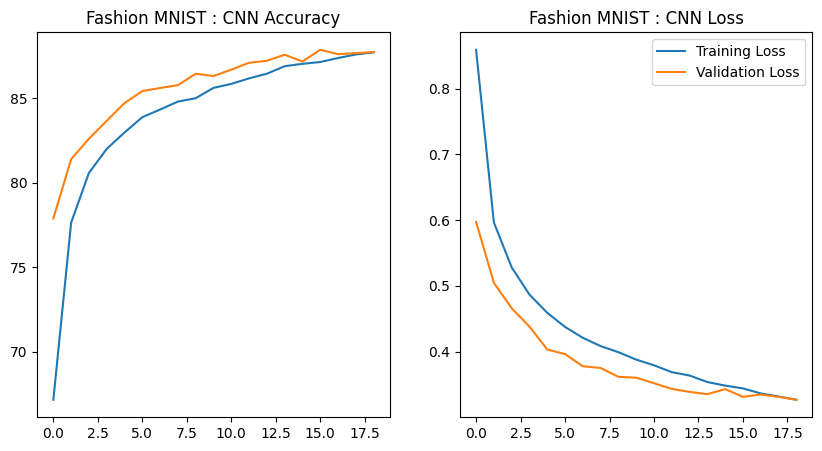

In [ ]:
title=['CNN Accuracy','CNN Loss']
model_losses=cnn_loss
fig=plt.figure(1,figsize=(10,5))

ax=fig.add_subplot(1,2,1)
ax.plot(model_losses['train_acc'],label="Training Accuracy")
ax.plot(model_losses['valid_acc'],label="Validation Accuracy")
ax.set_title('Fashion MNIST : '+title[0])
ax=fig.add_subplot(1,2,2)
ax.plot(model_losses['train'],label="Training Loss")
ax.plot(model_losses['valid'],label="Validation Loss")
ax.set_title('Fashion MNIST : '+title[1])
plt.legend();

## SCNN

### SCNN model loading from CNN

In [ ]:
learning_rate = 0.001
scnn_model = Net(num_steps=3,use_spike=True)
scnn_model.to(device)
print()

# Load the pure CNN weights to a dictionary
model_path = base_path + '/model/Net_cnn_quant8b_model.pth'
saved_model_state_dict = torch.load(model_path)
scnn_model_state_dict = scnn_model.state_dict()

params = saved_model_state_dict
params.keys()
# Copy weights layer by layer from the saved model to the new model
for name, param in saved_model_state_dict.items():
    if 'mainArch.0' in name:
        scnn_model_state_dict[name] = param

# Load the new model's state_dict with the copied weights
scnn_model.load_state_dict(scnn_model_state_dict)
scnn_model.to(device)
print()

### SCNN Training phase 1


*   Freeze layer 1




In [ ]:
# Freeze first layer before training
params = scnn_model.state_dict()
params.keys()

for name,param in scnn_model.named_parameters():
  if param.requires_grad and ('mainArch.0' in name):
      param.requires_grad = False

print("Trainable params")
for name,param in scnn_model.named_parameters():
  if param.requires_grad:
    print(name)

non_frozen_parameters = [p for p in scnn_model.parameters() if p.requires_grad]
opt_scnn = torch.optim.Adam(non_frozen_parameters,lr=learning_rate)
# print(len(non_frozen_parameters))

Trainable params
mainArch.1.conv.weight
mainArch.2.conv.weight
fcs.1.weight
fcs.1.bias
fcs.4.weight
fcs.4.bias
fcs.7.weight
fcs.7.bias


In [ ]:
name= '_scnn_frz1_quant8b_model.pth'
scnn_loss = trainNet(scnn_model, opt_scnn, name, 22)


Epoch : 1	Training Loss : 0.9500	 Validation Loss : 0.7000
-----------------Training Acc : 63.5750% 	Validation Acc: 73.1417%
Validation loss decreased from : inf ----> 0.6999753286441167 ----> Saving Model.......

Epoch : 2	Training Loss : 0.7253	 Validation Loss : 0.6522
-----------------Training Acc : 72.3917% 	Validation Acc: 75.3250%
Validation loss decreased from : 0.6999753286441167 ----> 0.652217855056127 ----> Saving Model.......

Epoch : 3	Training Loss : 0.6841	 Validation Loss : 0.6222
-----------------Training Acc : 74.0375% 	Validation Acc: 76.1250%
Validation loss decreased from : 0.652217855056127 ----> 0.6222307126969099 ----> Saving Model.......

Epoch : 4	Training Loss : 0.6642	 Validation Loss : 0.5985
-----------------Training Acc : 74.6813% 	Validation Acc: 77.3167%
Validation loss decreased from : 0.6222307126969099 ----> 0.5984949488192797 ----> Saving Model.......

Epoch : 5	Training Loss : 0.6497	 Validation Loss : 0.5947
-----------------Training Acc : 75.21

### SCNN phase 1 Results

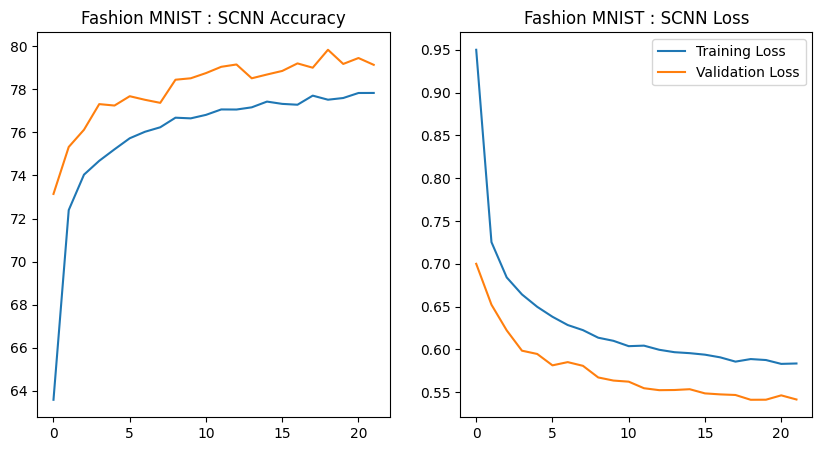

In [ ]:
title=['SCNN Accuracy','SCNN Loss']
fig=plt.figure(1,figsize=(10,5))
model_losses = scnn_loss

ax=fig.add_subplot(1,2,1)
ax.plot(model_losses['train_acc'],label="Training Accuracy")
ax.plot(model_losses['valid_acc'],label="Validation Accuracy")
ax.set_title('Fashion MNIST : '+title[0])
ax=fig.add_subplot(1,2,2)
ax.plot(model_losses['train'],label="Training Loss")
ax.plot(model_losses['valid'],label="Validation Loss")
ax.set_title('Fashion MNIST : '+title[1])
plt.legend();

### SCNN Training phase 2


*   Freeze 1st and 2nd layer



In [ ]:
for name, param in scnn_model.named_parameters():
    if param.requires_grad and ('mainArch.0' in name or 'mainArch.1' in name):
        param.requires_grad = False
    elif (not param.requires_grad) and ('mainArch.0' not in name or 'mainArch.1' in name):
      param.requires_grad = True

non_frozen_parameters = [p for p in scnn_model.parameters() if p.requires_grad]
opt_scnn = torch.optim.Adam(non_frozen_parameters,lr=0.000001)
print(len(non_frozen_parameters))

# for name,param in scnn_model.named_parameters():
#   if param.requires_grad:
#     print(name)

7


In [ ]:
name = '_scnn_frz2_quant8b_model.pth'
scnn_loss = trainNet(scnn_model, opt_scnn, name, 5)


Epoch : 1	Training Loss : 0.5755	 Validation Loss : 0.5365
-----------------Training Acc : 78.0333% 	Validation Acc: 79.3417%
Validation loss decreased from : inf ----> 0.536507040138046 ----> Saving Model.......

Epoch : 2	Training Loss : 0.5745	 Validation Loss : 0.5320
-----------------Training Acc : 78.2062% 	Validation Acc: 79.8000%
Validation loss decreased from : 0.536507040138046 ----> 0.531969353929162 ----> Saving Model.......

Epoch : 3	Training Loss : 0.5729	 Validation Loss : 0.5325
-----------------Training Acc : 78.2396% 	Validation Acc: 79.5667%

Epoch : 4	Training Loss : 0.5752	 Validation Loss : 0.5341
-----------------Training Acc : 77.8729% 	Validation Acc: 79.9917%

Epoch : 5	Training Loss : 0.5723	 Validation Loss : 0.5335
-----------------Training Acc : 78.0563% 	Validation Acc: 79.5083%


### SCNN phase 2 Results

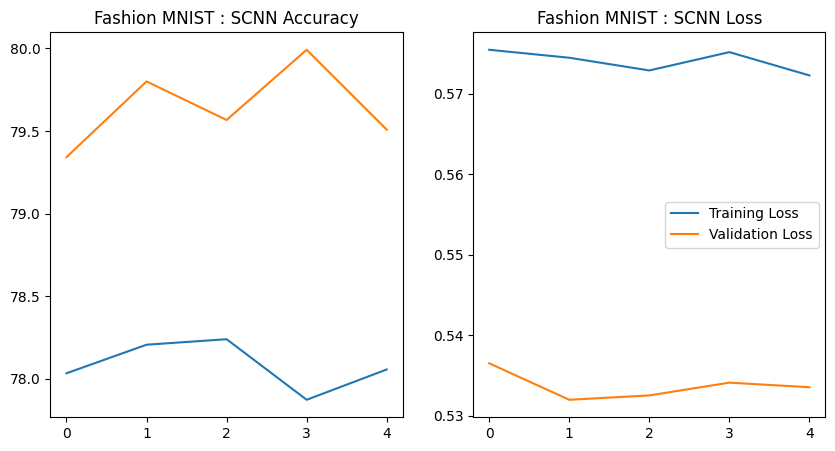

In [ ]:
title=['SCNN Accuracy','SCNN Loss']
fig=plt.figure(1,figsize=(10,5))
model_losses = scnn_loss

ax=fig.add_subplot(1,2,1)
ax.plot(model_losses['train_acc'],label="Training Accuracy")
ax.plot(model_losses['valid_acc'],label="Validation Accuracy")
ax.set_title('Fashion MNIST : '+title[0])
ax=fig.add_subplot(1,2,2)
ax.plot(model_losses['train'],label="Training Loss")
ax.plot(model_losses['valid'],label="Validation Loss")
ax.set_title('Fashion MNIST : '+title[1])
plt.legend();

## Confusion Matrix

In [ ]:
fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

# Build confusion matrix
def print_confusion_matrix(y_true, y_pred):
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in fashion_class],
                      columns = [i for i in fashion_class])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  fig_path = base_path + '/model/scnn_quant8b_cm.png'
  plt.savefig(fig_path)
  plt.close(fig)

## Test Loop

In [ ]:
def test(model):
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    #confusion matrix
    y_pred = []
    y_true = []

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        #confusion matrix
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss=test_loss/len(test_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {fashion_class[i]} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (fashion_class[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")

    print_confusion_matrix(y_true=y_true,y_pred=y_pred)
    # print_confusion_matrix_blue(y_true=y_true,y_pred=y_pred)


## Test Results

For Net :
Test Loss: 0.5532608278095722
Correctly predicted per class : [800.0, 919.0, 653.0, 805.0, 702.0, 890.0, 385.0, 875.0, 928.0, 936.0], Total correctly perdicted : 7893.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class T-shirt/top : 80.0% where 800 of 1000 were predicted correctly
Test Accuracy of class Trouser : 91.9% where 919 of 1000 were predicted correctly
Test Accuracy of class Pullover : 65.3% where 653 of 1000 were predicted correctly
Test Accuracy of class Dress : 80.5% where 805 of 1000 were predicted correctly
Test Accuracy of class Coat : 70.2% where 702 of 1000 were predicted correctly
Test Accuracy of class Sandal : 89.0% where 890 of 1000 were predicted correctly
Test Accuracy of class Shirt : 38.5% where 385 of 1000 were predicted correctly
Test Accuracy of class Sneaker : 87.5% where 875 of 1000 were predicted correctly
Test Accuracy of

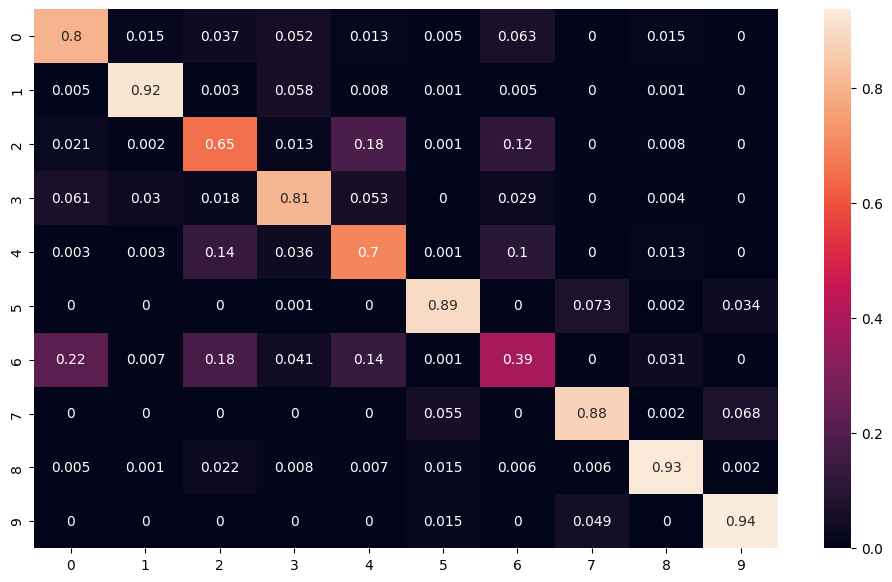

In [ ]:
test(scnn_model)

## Store Weights

Store quantized float weights and INT weights as numpy to drive

In [ ]:
import numpy as np
# Extract the weights from the specified layer
for name, module in scnn_model.named_modules():
  if isinstance(module, qnn.QuantConv2d) and 'mainArch.1.conv' in name :
    print(name)
    quant_weight_float = module.quant_weight().value
    quant_weight_int = module.quant_weight().int()

    print(quant_weight_float.shape)
    print(quant_weight_int.shape)
    print(module.quant_weight().scale)

    quant_weight_float = quant_weight_float.detach().cpu().numpy()
    quant_weight_int = quant_weight_int.detach().cpu().numpy()

# Path to the directory where you want to save the file
save_dir = base_path + '/model_weights/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
fweights_file_path = os.path.join(save_dir, 'quant_weight_float.npy')
iweights_file_path = os.path.join(save_dir, 'quant_weight_int.npy')

# Save the weights as numpy files
np.save(fweights_file_path, quant_weight_float)
np.save(iweights_file_path, quant_weight_int)

mainArch.1.conv
torch.Size([16, 8, 3, 3])
torch.Size([16, 8, 3, 3])
tensor(0.0099, device='cuda:0')
